In [1]:
import glob
import os
import json
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import copy
import cPickle as pkl

from pipeline.python.utils import natural_keys, label_figure
from pipeline.python.classifications import linearSVC_class as lsvc

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/combine_runs.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [2]:
import pylab as pl
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter


In [889]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, permutation_test_score, cross_val_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


In [3]:
%matplotlib notebook

#### Set data source

In [4]:
# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC026'
# session = '20181207' #'20181209'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001'

# traceid_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run, 'traces', '%s*' % traceid))[0]
# data_fpath = os.path.join(traceid_dir, 'data_arrays', 'datasets.npz')


In [459]:
class struct():
    pass

class DataSet():
    
    def __init__(self, animalid='RATID', session='YYYYMMDD', fov='FOV1_zoom1p0x', run='experiment_run1', 
                 traceid='traces00x', rootdir='/n/coxfs01/2p-data'):
        self.rootdir=rootdir
        self.animalid = animalid
        self.session = session
        self.fov = fov
        self.run = run
        self.traceid = traceid
        datafiles = glob.glob(os.path.join(rootdir, animalid, session, \
                                           '%s*' % fov, run, 'traces', '%s*' % traceid, \
                                           'data_arrays', 'datasets*.npz'))
        if len(datafiles) > 1:
            for fi, df in enumerate(sorted(datafiles)):
                print(fi, df)
            sel = int(input('Sel IDX of traceid to use: '))
            dpath = sorted(datafiles)[sel]
        else:
            dpath = datafiles[0]
        self.source = dpath
        
        self.data_identifier = '_'.join((animalid, session, fov, run, traceid))

        self.datasets = {}
    

    def load_dataset(self, roi_selector='visual', visual_area='visual_area_name', segmented_areas_fpath=None):
        
        print("------------ Loading dataset.")
        # Store DATASET:            
        dt = np.load(self.source)
        if 'arr_0' in dt.keys():
            dataset = dt['arr_0'][()]
        else:
            dataset = dt           

        # Store run info:
        if isinstance(dataset['run_info'], dict):
            run_info = dataset['run_info']
        else:
            run_info = dataset['run_info'][()]
        
        # Store stim configs:
        if isinstance(dataset['sconfigs'], dict):
            orig_sconfigs = dataset['sconfigs']
        else:
            orig_sconfigs = dataset['sconfigs'][()]

        # Make sure numbers are rounded:
        for cname, cdict in orig_sconfigs.items():
            for stimkey, stimval in cdict.items():
                if isinstance(stimval, (int, float)):
                    orig_sconfigs[cname][stimkey] = round(stimval, 1)
                    
        # Add combined 'position' variable to stim configs:
        for cname, config in orig_sconfigs.items():
            pos = '_'.join([str(config['xpos']), str(config['ypos'])])
            orig_sconfigs[cname].update({'position': pos})
        
        # Correct for old naming scheme for morph levels:
        if int(self.session) < 20180602:
            # Rename morphs:
            update_configs = [cfg for cfg, info in orig_sconfigs.items() if info['morphlevel'] > 0]
            for cfg in update_configs:
                if orig_sconfigs[cfg]['morphlevel'] == 6:
                    orig_sconfigs[cfg]['morphlevel'] = 27
                elif orig_sconfigs[cfg]['morphlevel'] == 11:
                    orig_sconfigs[cfg]['morphlevel'] = 53
                elif orig_sconfigs[cfg]['morphlevel'] == 16:
                    orig_sconfigs[cfg]['morphlevel'] = 79
                elif orig_sconfigs[cfg]['morphlevel'] == 22:
                    orig_sconfigs[cfg]['morphlevel'] = 106
                else:
                    print("Unknown morphlevel converstion: %i" % orig_sconfigs[cfg]['morphlevel'])
        
        # Make sure specified const_trans are actually tested transforms:
        sdf = pd.DataFrame(orig_sconfigs).T
#         id_preserving_transforms = ['xpos', 'ypos', 'size', 'yrot']
#         true_trans_dict = dict((tkey, list(set(sdf[tkey]))) for tkey in id_preserving_transforms)
#         varying_transforms = [t for t,vals in true_trans_dict.items() if len(vals) > 1]
    
        visual_areas_fpath=''; included_rois=None; areas=None;
        if segmented_areas_fpath is not None:
            print("Getting ROIs for area: %s" % visual_area)
            print("Loading file:", segmented_areas_fpath)
            with open(segmented_areas_fpath, 'rb') as f:
                areas = pkl.load(f)
            if visual_area not in areas.regions.keys():
                print("Specified visual area - %s - NOT FOUND.")
                for vi, va in enumerate(areas.regions.keys()):
                    print(vi, va)
                sel = input("Select IDX of area to use: ")
                visual_area = areas.regions.keys()[sel]
            included_rois = [int(ri) for ri in areas.regions[visual_area]['included_rois']]
        else:
            included_rois = None
        
        brain_region = {}
        brain_region['name'] = visual_area
        brain_region['source'] = segmented_areas_fpath
        brain_region['roi_indices'] = included_rois
        brain_region['segmentation'] = None if areas is None else areas.regions[visual_area]  
        
        self.update_data(dataset, sdf, run_info, brain_region, roi_selector=roi_selector)

    def load_roi_list(self, roi_selector='visual'):
        
        traceid_dir = glob.glob(os.path.join(self.rootdir, self.animalid, self.session, '%s*' % self.fov, run, 'traces', '%s*' % self.traceid))[0]
        
        if roi_selector == 'all':
            roi_list = None
        else:
            roistats_results_fpath = os.path.join(traceid_dir, 'sorted_rois', 'roistats_results.npz')
            roistats = np.load(roistats_results_fpath)

            roi_subset_type = 'sorted_%s' % roi_selector
            roi_list = roistats[roi_subset_type]

        return roi_list

    def update_data(self, dataset, sdf, run_info, brain_region, roi_selector='visual'):
        d = struct()
        
        # Get visual rois:
        visual_rois = self.load_roi_list(roi_selector=roi_selector)
        if visual_rois is None:
            visual_rois = np.arange(0, dataset['corrected'].shape[1])
    
        # Get subset of rois within specified visual area:
        rois_in_visual_area=None
        if brain_region['roi_indices'] is not None:
            rois_in_visual_area = np.array(brain_region['roi_indices'])
        
        # Get final roi indices:
        if rois_in_visual_area is not None:
            roi_indices = intersection(visual_rois, rois_in_visual_area)
        else:
            roi_indices = visual_rois.copy()
    
        # Get subset of roi traces specified:
        traces = dataset['corrected'][:, roi_indices]
        
        # Get labels dataframe (for traces):
        labels = pd.DataFrame(data=dataset['labels_data'], columns=dataset['labels_columns'])
        
        d.traces = traces
        d.labels = labels
        d.roi_indices = roi_indices
        d.conditions = sdf
        d.run_info = run_info
        d.brain_region = brain_region
        
        self.datasets.update({'%s' % brain_region['name']: d})
        

In [460]:
def get_formatted_data(xdata, labels, multiple_durs=True, data_type='stat', stat_type='meanstim', get_null=False): #get_training_data(self):
    '''
    Returns input data formatted as:
        ntrials x nrois (data_type=='stat')
        nframes x nrois (data_type = 'frames')
    Filters nrois by roi_selector.
    '''
    print("------------ Formatting data into samples.")


    # Determine whether all trials have the same structure or not:
    multiple_durs = len(list(set(labels['nframes_on']))) > 1

    if data_type == 'stat':
        cX, cy = get_stat_samples(xdata, labels, multiple_durs=multiple_durs, stat_type=stat_type, get_null=get_null)
    else:
        cX, cy = get_frame_samples(xdata, labels, self.params)

    print("Ungrouped dataset cX:", cX.shape)
    print("Ungrouped dataset labels cy:", cy.shape)

    return cX, cy

In [461]:

def get_stat_samples(traces, labels, multiple_durs=True, stat_type='meanstim', get_null=False):
    ntrials_total = len(labels['trial'].unique())
    ntrials_per_cond = [len(t) for t in labels.groupby('config')['trial'].unique()]
    if len(np.unique(ntrials_per_cond)) > 1:
        print("***warning*** uneven reps per condition: %s" % str(np.unique(ntrials_per_cond)))
    #assert len(np.unique(ntrials_per_cond)) == 1, "Uneven reps per condition! %s" % str(ntrials_per_cond)
    ntrials = np.unique(ntrials_per_cond)[0]
    
    # Get baseline and stimulus indices for each trial:
    sample_labels = []
    stim_on_frame = labels['stim_on_frame'].unique()
    assert len(stim_on_frame) == 1, "More than 1 stim on frame found! %s" % str(stim_on_frame)
    stim_on_frame = stim_on_frame[0]
    if multiple_durs:
        tgroups = labels.groupby('trial')            
        std_baseline_values=[]; mean_baseline_values=[]; mean_stimulus_values=[];
        for k,g in tgroups:
            curr_nframes_on = g['nframes_on'].unique()[0]

            curr_baseline_stds = np.nanstd(traces[g['tsec'][0:stim_on_frame].index.tolist(), :], axis=0)
            curr_baseline_means = np.nanmean(traces[g['tsec'][0:stim_on_frame].index.tolist(), :], axis=0)

            curr_stimulus_means = np.nanmean(traces[g['tsec'][stim_on_frame:stim_on_frame+curr_nframes_on].index.tolist(), :], axis=0)
            
            std_baseline_values.append(curr_baseline_stds)
            mean_baseline_values.append(curr_baseline_means)
            mean_stimulus_values.append(curr_stimulus_means)
            
            curr_config = g['config'].unique()[0]
            sample_labels.append(curr_config)
        
        mean_stim_on_values = np.vstack(mean_stimulus_values)
        mean_baseline_values = np.vstack(mean_baseline_values)
        std_baseline_values = np.vstack(std_baseline_values)
        
    else:
        nrois = traces.shape[-1]
        nframes_per_trial = traces.shape[0] / ntrials_total
        assert len(labels['nframes_on'].unique()) == 1, "Uneven num frames stim ON: %s" % str(labels['nframes_on'].unique())
        nframes_on = labels['nframes_on'].unique()[0]
        
        tracemat = np.reshape(traces, (ntrials_total, nframes_per_trial, nrois), order='C')
        sample_labels = np.reshape(labels['config'].tolist(), (ntrials_total, nframes_per_trial), order='C')[:, 0]
        
        std_baseline_values = np.nanstd(tracemat[:, 0:stim_on_frame], axis=1)
        mean_baseline_values = np.nanmean(tracemat[:, 0:stim_on_frame], axis=1)
        mean_stim_on_values = np.nanmean(tracemat[:, stim_on_frame:stim_on_frame+nframes_on], axis=1)
            
    if stat_type == 'zscore':
        sample_array = (mean_stim_on_values - mean_baseline_values ) / std_baseline_values
    elif stat_type == 'meanstimdff':
        sample_array = (mean_stim_on_values - mean_baseline_values ) / mean_baseline_values
    else:
        sample_array = mean_stim_on_values.copy()
    
    if get_null:
        random_draw = True
        print("Stim values:", sample_array.shape)
        if random_draw:
            selected_trial_ixs = random.sample(range(0, mean_baseline_values.shape[0]), ntrials)
        bas = mean_baseline_values[selected_trial_ixs, :]
    
        sample_array = np.append(sample_array, bas, axis=0)
        print("Added null cases:", sample_array.shape)
        sample_labels.extend(['bas' for _ in range(bas.shape[0])])
    
    return sample_array, np.array(sample_labels)

In [462]:
def get_best_C(svc_in, cX, cy, output_dir=None, figname=None, close=True):
    # Look at cross-validation scores as a function of parameter C
    svc = copy.copy(svc_in)
    C_s = np.logspace(-10, 10, 50)
    scores = list()
    scores_std = list()
    for C in C_s:
        svc.C = C
        this_scores = cross_val_score(svc, cX, cy, n_jobs=1)
        scores.append(np.mean(this_scores))
        scores_std.append(np.std(this_scores))

    # Do the plotting
    pl.figure(figsize=(4,4))
    pl.semilogx(C_s, scores)
    pl.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
    pl.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
    locs, labels = pl.yticks()
    pl.yticks(locs, list(map(lambda x: "%g" % x, locs)))
    pl.ylabel('CV score')
    pl.xlabel('Parameter C')
    pl.ylim(0, 1.1)

    best_idx_C = scores.index(np.max(scores))
    best_C = C_s[best_idx_C]
    pl.title('best C: %0.4f' % best_C)

    if output_dir is not None:
        if figname is None:
            figname = 'crossval_score_by_C.png'
        pl.savefig(os.path.join(output_dir, figname))
        if close:
            pl.close()

    return best_C



In [463]:

def plot_confusion_matrix(cmatrix, classes,
                          ax=None,
                          normalize=False,
                          title='Confusion matrix', clim=None,
                          cmap=pl.cm.Blues, cmin=0, cmax=1.0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cmatrix = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        if clim=='max':
            cmax = cmatrix.max()
    else:
        print('Confusion matrix, without normalization')

    if ax is None:
        fig = pl.figure(figsize=(4,4))
        ax = fig.add_subplot(111)

    ax.set_title(title, fontsize=10)

    im = ax.imshow(cmatrix, interpolation='nearest', cmap=cmap, vmax=cmax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=8)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=8)
    fmt = '.1f' if normalize else 'd'
    thresh = cmatrix.max() #/ 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        ax.text(j, i, format(cmatrix[i, j], fmt),
                 horizontalalignment="center", fontsize=6,
                 color="white" if cmatrix[i, j] > thresh else "black")

    #pl.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    pl.colorbar(im, cax=cax)

    return ax

In [464]:
def group_by_class(cX, cy, conditions, class_name='CLASS'):
    cy_tmp = cy.copy()
    cy = np.array([conditions.loc[cv][class_name] if cv != 'bas' else 'bas' for cv in cy_tmp])
    class_labels = sorted(list(set(cy))) 
    return cX, cy, class_labels

# Create DataSet object:

In [465]:
# roi_selector = 'visual'
# data_type='stat'
# stat_type='meanstim'
# inputdata_type='corrected'
# get_null=False

# class_name='size'
# class_subset=''
# const_trans=''
# trans_value=''
# test_set=[]
# indie=False

# cv_method='kfold'
# cv_nfolds=5
# cv_ngroups=1
# C_val=1e9

# binsize=10
# nprocesses=1
# select_visual_area=False
# visual_area='LI'


In [2936]:

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC026'
# session = '20191209' #'20181207' #'20181209'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_gratings_static' #combined_blobs_static'
# traceid = 'traces001'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC031'
# session = '20181118' #'20181207' #'20181209'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_gratings_static' #combined_blobs_static'
# traceid = 'traces001'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC022'
# session = '20181005' #'20181207' #'20181209'
# fov = 'FOV2_zoom2p7x'
# run = 'combined_gratings_static' #combined_blobs_static'
# traceid = 'traces001'


# ---- blobs?:  size transform ----
# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC026'
# session = '20181209'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001'
# segment_visual_area = False
# visual_area = 'LI'


# ---- gratings:  size transform ----
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC026'
session = '20181209'
fov = 'FOV1_zoom2p0x'
run = 'combined_gratings_static'
traceid = 'traces001'
segment_visual_area = False
visual_area = 'LI'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC005'
# session = '20180723'
# fov = 'FOV1_zoom1x'
# run = 'gratings_run1' #combined_blobs_static'
# traceid = 'traces001'
# segment_visual_area = False
# visual_area = 'LI'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC013'
# session = '20180907'
# fov = 'FOV2_zoom1x'
# run = 'gratings_run1' #combined_blobs_static'
# traceid = 'traces001'
# segment_visual_area = False
# visual_area = 'LI'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC007'
# session = '20180810'
# fov = 'FOV1_zoom1x'
# run = 'gratings_run1' #combined_blobs_static'
# traceid = 'traces002'
# segment_visual_area = False
# visual_area = 'V1'




# ------ V1 ? ------
# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC007'
# session = '20180810' #'20181207' #'20181209'
# fov = 'FOV1_zoom1x'
# run = 'blobs_run2' #combined_blobs_static'
# traceid = 'traces002'
# segment_visual_area = False
# visual_area = 'V1'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC024'
# session = '20181013' #'20181207' #'20181209'
# fov = 'FOV1_zoom2p7x'
# run = 'combined_blobs_static' #combined_blobs_static'
# traceid = 'traces001'
# segment_visual_area = False
# visual_area = 'V1'


# ------ LM ------
# rootdir = '/n/coxfs01/2p-data'
# animalid = 'CE077' #'JC026'
# session = '20180521' #'20180518' #'20180602' #'20180523' #'20180521'
# fov = 'FOV2_zoom1x' #'FOV1_zoom1x' #'FOV1_zoom1x' #'FOV1_zoom1x' #'FOV2_zoom1x'
# run = 'combined_blobs_static' #'combined_blobs_static' #'combined_blobs_static' #'combined_blobs_static' #'combined_blobs_static'
# traceid = 'traces002' #'traces002' #'traces001' #'traces002' # 'traces002'
# visual_area = 'LM'
# segment_visual_area = False

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC015'
# session = '20180919' #'20181207' #'20181209'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static' #combined_blobs_static'
# traceid = 'traces003'
# visual_area = 'LM'

# ------ LI ------
# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC022'
# session = '20181018' #'20181207' #'20181209'
# fov = 'FOV2_zoom2p7x'
# run = 'combined_blobs_static' #combined_blobs_static'
# traceid = 'traces001'
# segment_visual_area = False
# visual_area = 'LI/LL'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC022'
# session = '20181016' #20181018'
# fov = 'FOV2_zoom2p7x' #'FOV2_zoom2p7x'
# run = combined_blobs_static' #combined_blobs_static'
# traceid = 'traces001' #'traces001'
# segment_visual_area = False
# visual_area = 'LI/LL'


# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC026'
# session = '20181209'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_morphs_static'
# traceid = 'traces001'
# segment_visual_area = False
# visual_area = 'LI'


In [2937]:
D = DataSet(animalid=animalid, session=session, fov=fov, run=run, traceid=traceid)


In [2938]:
print(D.source)

/n/coxfs01/2p-data/JC026/20181209/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_6d2adc_traces001_76494d_traces001_25a3b0_traces001_6ce7bd/data_arrays/datasets.npz


In [2939]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 


In [2940]:
if segment_visual_area:
    segmented_files = sorted(glob.glob(os.path.join(D.rootdir, D.animalid, D.session, D.fov, 'visual_areas', 'segmentation_*.pkl')), key=natural_keys)[::-1]
    segmented_areas_fpath = segmented_files[0]
else:
    segmented_areas_fpath = None

In [2941]:
D.load_dataset(roi_selector='visual', visual_area=visual_area, segmented_areas_fpath=segmented_areas_fpath)
print(D.datasets)
print("%s: \n" % visual_area, dir(D.datasets[visual_area]))

------------ Loading dataset.
{'LI': <__main__.struct instance at 0x7f3e837cae60>}
LI: 
 ['__doc__', '__module__', 'brain_region', 'conditions', 'labels', 'roi_indices', 'run_info', 'traces']


In [2942]:
if segment_visual_area:
    print(D.datasets[visual_area].roi_indices)
    print(len(D.datasets[visual_area].roi_indices))

In [2943]:
d = D.datasets[visual_area]
print("--- raw traces:", d.traces.shape)
print("--- corresp. labels:", d.labels.shape)
print("--- conditions dataframe:\n", d.conditions.head())

--- raw traces: (100480, 83)
--- corresp. labels: (100480, 6)
--- conditions dataframe:
           direction ori   position   sf size speed  stimtype xpos ypos
config001         0   0  -14.0_5.0  0.1    7    10  gratings  -14    5
config002         0   0   14.0_5.0  0.1    7    10  gratings   14    5
config003         0   0  -14.0_5.0  0.1   17    10  gratings  -14    5
config004         0   0   14.0_5.0  0.1   17    10  gratings   14    5
config005         0   0  -14.0_5.0  0.1   27    10  gratings  -14    5


In [2944]:

print("xpos:", list(set(d.conditions['xpos'])))
print("ypos:", list(set(d.conditions['ypos'])))
print("size:", list(set(d.conditions['size'])))
if 'morphlevel' in d.conditions.columns.tolist():
    print("morphlevel:", list(set(d.conditions['morphlevel'])))
print(d.run_info['trans_types'])

xpos: [-14.0, 14.0]
ypos: [5.0]
size: [17.0, 27.0, 37.0, 7.0]
['ori', 'size', 'xpos']


In [2945]:
sample_data, sample_labels = get_formatted_data(d.traces, d.labels)
print(sample_data.shape)
print(sample_labels.shape)
        

------------ Formatting data into samples.
Ungrouped dataset cX: (640, 83)
Ungrouped dataset labels cy: (640,)
(640, 83)
(640,)


In [2946]:
D.session

'20181209'

In [2947]:
# # -------------------------------------------------------------------------
# # MODEL SELECTION PARAMS:
# feature_select_method='rfe' #'rfe' #'rfe'
# feature_select_n='best' #'best' #'best'
# C_select='big' #'best'
# # -------------------------------------------------------------------------

# # -------------------------------------------------------------------------
# # TRAINING PARAMS:
# scoring = 'accuracy'
# full_train = False
# test_size = 0.2 #0.33 #0.33 #0.20 #0.33 #0.33
# create_new = True

# m50 = 53
# m100 = 106 #106

# col_label = 'xpos' # 'xpos'
# row_label = 'ypos' #'ypos'

# Select train and test sets

In [2948]:
print("Transforms tested:", d.run_info['trans_types'])
transforms = {}
for trans in d.run_info['trans_types']:
    transforms[trans] = list(set(d.conditions[trans]))
transforms

Transforms tested: ['ori', 'size', 'xpos']


{'ori': [0.0, 90.0, 180.0, 270.0],
 'size': [17.0, 27.0, 37.0, 7.0],
 'xpos': [-14.0, 14.0]}

In [2949]:
find_best_stimulus = False

# which is the best position?
if find_best_stimulus:

    class_name='position'
    cX, cy, train_labels = group_by_class(sample_data, sample_labels, d.conditions, class_name=class_name)
    cX = StandardScaler().fit_transform(cX)

    print("Train data:", cX.shape)
    print("Train labels:", train_labels)

    dual = cX.shape[0] > cX.shape[1]
    svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=1e9) #, C=self.clfparams['C_val'])

    best_C = get_best_C(svc, cX, cy)

    C = best_C

    svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=C) #, C=self.clfparams['C_val'])

    rfe = RFECV(estimator=svc, step=1, cv=StratifiedKFold(cv_nfolds), scoring=scoring, n_jobs=1)
    fit = rfe.fit(cX, cy)

    best_score = fit.grid_scores_[fit.n_features_ - 1]
    kept_rids = fit.get_support(indices=True)
    nfeatures_best = len(kept_rids) #fit.n_features_
    print("N features", nfeatures_best, fit.n_features_, fit.grid_scores_.shape)
    all_scores = fit.grid_scores_

    fig = pl.figure(figsize=(4,4))
    pl.plot(range(1, len(all_scores) + 1), all_scores)
    pl.xlabel("N features selected")
    pl.ylabel(scoring)
    pl.title("optimal: %i" % len(kept_rids))

    fit_best = True

    if fit_best:
        roi_indices = kept_rids.copy()
    else:
        roi_indices = np.arange(0, cX.shape[1])


    xdata = cX[:, kept_rids]
    xlabels = cy

    dual = xdata.shape[0] > xdata.shape[1]
    svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=best_C) #, C=self.clfparams['C_val'])


In [2950]:
transforms

{'ori': [0.0, 90.0, 180.0, 270.0],
 'size': [17.0, 27.0, 37.0, 7.0],
 'xpos': [-14.0, 14.0]}

# Choose classes to train

##### Create output dirs

In [2951]:
        
classifier_regime = 'decode_ori_train_test_size'
#classifier_regime = 'decode_AB_train_anchors_test_morphs'

In [2952]:
fov_list = [D.fov]
session_list = [D.session]
traceid_list = [D.traceid]

for vi, (fv, sv, tv) in enumerate(zip(fov_list, session_list, traceid_list)):
    fov_list[vi] = '_'.join([sv, fv.split('_zoom')[0], tv])
print(fov_list)
fov_dirname = '_'.join(fov_list)
if segment_visual_area:
    fov_dirname = '%s_segmented%s' % (fov_dirname, visual_area)

session_list = [D.session]


if '/' in visual_area: 
    visual_area = visual_area.replace('/', '_')

output_dir = os.path.join(D.rootdir, D.animalid, visual_area, fov_dirname, 'classifiers', classifier_regime)
if not os.path.exists(output_dir): os.makedirs(output_dir)
print("Saving output figures:\n%s" % output_dir)

['20181209_FOV1_traces001']
Saving output figures:
/n/coxfs01/2p-data/JC026/LI/20181209_FOV1_traces001/classifiers/decode_ori_train_test_size


# Set training stimulus set

In [2953]:
transforms

{'ori': [0.0, 90.0, 180.0, 270.0],
 'size': [17.0, 27.0, 37.0, 7.0],
 'xpos': [-14.0, 14.0]}

In [2956]:
# Get list of configs with specified params:
class_name = 'ori'

#xpos = [14] # [-5]
#ypos = [5] #[0]
xpos = [-14] #[-28, -16.8] #list(set(d.conditions['xpos'])) #[5.6, 28, 16.8]
ypos = []

yrot = []
size = []


positions = list(set(d.conditions['position']))

transform_spanned = 'size' #'position' #'size' #'position'
if transform_spanned is None:
    test_transforms = []
    train_transforms = []
else:
    all_transform_values = list(set(d.conditions[transform_spanned]))
    test_transforms = [17] #[20, 25] #['0.0_5.0', '14.0_5.0'] #[7, 27] 
    train_transforms = [p for p in all_transform_values if p not in test_transforms] # [17, 37] #[p for p in positions if p not in test_transforms]


# -------------------------------------------------------------------------
train_anchors = False
all_classes = sorted(list(set(d.conditions[class_name]))) #[0, 106]
#train_classes = [all_classes[0], all_classes[-1]]

if train_anchors:
    train_classes = [all_classes[0], all_classes[-1]]
    test_classes = [i for i in list(set(d.conditions[class_name])) if i not in train_classes]
else:
    train_classes = copy.copy(all_classes)
    test_classes = copy.copy(train_classes) #[0, 106]
    
print("train classes:", train_classes)
print("test classes:", test_classes)
# -------------------------------------------------------------------------

if len(yrot) > 0: #'yrot' in d.conditions.columns.tolist():
    sdf = d.conditions[(d.conditions['yrot'].isin(yrot))]
else:
    sdf = d.conditions.copy()

if len(xpos) > 0:
    sdf = sdf[(sdf['xpos'].isin(xpos))]
if len(ypos) > 0:
    sdf = sdf[(sdf['ypos'].isin(ypos))]


if len(size) > 0:
    sdf = sdf[(sdf['size'].isin(size))]

#
train_transform_subset = True
# 
if train_transform_subset:
    train_sdf = sdf[sdf[transform_spanned].isin(train_transforms)]
    test_sdf = sdf[sdf[transform_spanned].isin(test_transforms)]
else:
    train_sdf = sdf.copy()
    test_sdf = sdf.copy()
    

train_configs = train_sdf[train_sdf[class_name].isin(train_classes)].index.tolist()
test_configs = test_sdf[test_sdf[class_name].isin(test_classes)].index.tolist()

print("-- train configs:", train_configs)
print("-- test configs:", test_configs)

train classes: [0.0, 90.0, 180.0, 270.0]
test classes: [0.0, 90.0, 180.0, 270.0]
-- train configs: ['config001', 'config005', 'config007', 'config009', 'config013', 'config015', 'config017', 'config021', 'config023', 'config025', 'config029', 'config031']
-- test configs: ['config003', 'config011', 'config019', 'config027']


In [2957]:
import random

print(sample_data.shape)
trial_groups = d.labels.groupby('trial') #shape
trial_mapping = {}
for tcounter, (t,g) in enumerate(trial_groups):
    trial_mapping[t] = tcounter

if len(trial_mapping.keys()) < int(t[5:]):
    print("Trials are not sequentially labeled (skipped trials)")
    train_indices = [int(trial_mapping[trial]) for trial, trialdf in trial_groups if trialdf['config'].isin(train_configs).all()]
    test_indices =  [int(trial_mapping[trial]) for trial, trialdf in trial_groups if trialdf['config'].isin(test_configs).all()]
else:
    train_indices = [int(trial[5:])-1 for trial, trialdf in trial_groups if trialdf['config'].isin(train_configs).all()]
    test_indices =  [int(trial[5:])-1 for trial, trialdf in trial_groups if trialdf['config'].isin(test_configs).all()]

split_train_test = False
nsame_cfgs = sum([1 if tr==ts else 0 for tr, ts in zip(train_indices, test_indices)])
if nsame_cfgs == len(train_indices):
    print("@@Same test and train configs!@@")
    split_train_test = True
    
# perc_test = 0.20
# if split_train_test:
#     n_test_samples = int(len(train_indices) * perc_test)
#     test_indices = random.sample(range(0, len(train_indices)), n_test_samples)

print("Total %i training trials." % (len(train_indices)))
print("Total %i testing trials." % (len(test_indices)))
    

(640, 83)
Total 240 training trials.
Total 80 testing trials.


In [2958]:
data_in = StandardScaler().fit_transform(sample_data)
print("All trials:", sample_data.shape)
traindata = data_in[train_indices, :]
trainlabels = sample_labels[train_indices]

testdata = data_in[test_indices,:]
testlabels = sample_labels[test_indices]


All trials: (640, 83)


In [2959]:
print(len(list(set(trainlabels))))
counts_by_train_config = Counter(trainlabels)
for cfg, n in counts_by_train_config.items():
    print(cfg, n)

12
config021 20
config007 20
config023 20
config031 20
config025 20
config001 20
config029 20
config005 20
config009 20
config013 20
config015 20
config017 20


#### Create TRAIN and TEST sets:

In [2960]:
print("CLASS: %s" % class_name)

cX, cy, train_labels = group_by_class(traindata, trainlabels, d.conditions, class_name=class_name)
print("Train data:", cX.shape)
print("Train labels:", train_labels)


test_cx, test_cy, test_labels = group_by_class(testdata, testlabels, d.conditions, class_name=class_name)
print("Test data:", test_cx.shape)
print("Train labels:", test_labels)



CLASS: ori
Train data: (240, 83)
Train labels: [0.0, 90.0, 180.0, 270.0]
Test data: (80, 83)
Train labels: [0.0, 90.0, 180.0, 270.0]


In [2961]:
cv_nfolds = 5
scoring = 'accuracy'

# Model selection

In [2962]:
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)

# Loading the Digits dataset


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = cX.shape[0]
X = StandardScaler().fit_transform(cX)
y = cy.copy()

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(multi_class='ovr', dual=X_train.shape[0] > X_train.shape[1]), 
                                 tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.01}

Grid scores on development set:

0.345 (+/-0.132) for {'C': 0.001}
0.356 (+/-0.087) for {'C': 0.01}
0.275 (+/-0.081) for {'C': 0.1}
0.284 (+/-0.044) for {'C': 1}
0.265 (+/-0.108) for {'C': 10}
0.238 (+/-0.138) for {'C': 100}
0.249 (+/-0.135) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.33      0.44      0.38         9
       90.0       0.27      0.21      0.24        14
      180.0       0.18      0.18      0.18        11
      270.0       0.57      0.57      0.57        14

avg / total       0.35      0.35      0.35        48


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.01}

Grid scores on deve

###### Find best C:

bestC_train_size27_37_7_x-14_y_sz.png


<IPython.core.display.Javascript object>


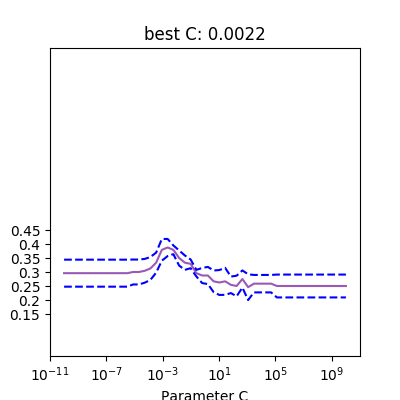

In [2963]:

test_with_rfe=False

figname = 'bestC%s' % '_fit_rfe' if test_with_rfe else 'bestC'
if train_transform_subset:
    figname = '%s_train_%s%s' % (figname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))
    
    
if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
    figname = '%s_x%s_y%s_sz%s.png' % (figname, '_'.join([str(int(x)) for x in xpos]), \
                                  '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))
else:
    figname = '%s.png' % figname
    
print(figname)

if test_with_rfe:
    dual = cX[:, kept_rids].shape[0] > cX[:, kept_rids].shape[1]
else:
    dual = cX.shape[0] > cX.shape[1]
    
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=1) #, C=self.clfparams['C_val'])

if test_with_rfe:
    bestC = get_best_C(svc, StandardScaler().fit_transform(cX[:, kept_rids]), cy, output_dir=output_dir, figname=figname, close=False)
else:
    bestC = get_best_C(svc, StandardScaler().fit_transform(cX), cy, output_dir=output_dir, figname=figname, close=False)



##### RFE to find best features for decoding accuracy

(240, 83)
C: bestC, 0.00222299648253
N features 13 13 (83,)


<IPython.core.display.Javascript object>


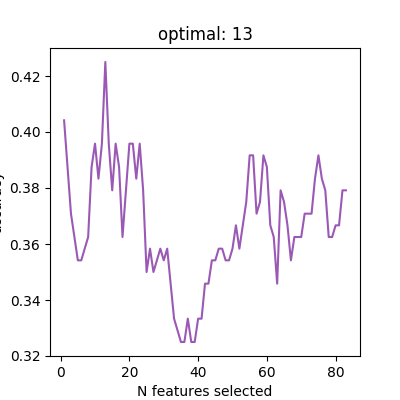

fitRFE_bestC_train_size27_37_7_x-14_y_sz.png


In [2964]:
# Can find best features first (C=1, or biC or defaultC...), then go back and re-run bestC

bigC = 1e9
defaultC = 1.0

dual = cX.shape[0] > cX.shape[1]
print(cX.shape)
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=bestC) #, C=self.clfparams['C_val'])

if svc.C == bigC:
    C_str = 'bigC'
elif svc.C == 1:
    C_str = 'defaultC'
else:
    C_str = 'bestC'
print("C: %s," % C_str, svc.C)

rfe = RFECV(estimator=svc, step=1, cv=StratifiedKFold(cv_nfolds), scoring=scoring, n_jobs=1)
fit = rfe.fit(StandardScaler().fit_transform(cX), cy)
#fit = rfe.fit(cX, cy)

best_score = fit.grid_scores_[fit.n_features_ - 1]
kept_rids = fit.get_support(indices=True)
nfeatures_best = len(kept_rids) #fit.n_features_
print("N features", nfeatures_best, fit.n_features_, fit.grid_scores_.shape)
all_scores = fit.grid_scores_


fig = pl.figure(figsize=(4,4))
pl.plot(range(1, len(all_scores) + 1), all_scores)
pl.xlabel("N features selected")
pl.ylabel(scoring)
pl.title("optimal: %i" % len(kept_rids))

figname = 'fitRFE_%s' % C_str
if train_transform_subset:
    figname = '%s_train_%s%s' % (figname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))
    
if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
    figname = '%s_x%s_y%s_sz%s.png' % (figname, '_'.join([str(int(x)) for x in xpos]), \
                                  '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))
else:
    figname = '%s.png' % figname
    
pl.savefig(os.path.join(output_dir, figname))
print(figname)

#### Get subset of data based on hyperparameter tuning

In [2965]:

fit_best = True

if fit_best:
    roi_indices = kept_rids.copy()
else:
    roi_indices = np.arange(0, cX.shape[1])

    
xdata = StandardScaler().fit_transform(cX[:, roi_indices])
xlabels = cy
print(xdata.shape)

(240, 13)


In [2966]:
C = bestC

print("bestC:", bestC)
dual = xdata.shape[0] > xdata.shape[1]
print("dual:", dual)
print(xdata.shape)
svc = LinearSVC(random_state=0, dual=dual, C=C) #multi_class='ovr') #, C=self.clfparams['C_val'])


bestC: 0.00222299648253
dual: True
(240, 13)


In [2967]:
print(len(kept_rids))
xdata_test = StandardScaler().fit_transform(test_cx[:, kept_rids])
xlabels_test = test_cy
    


13


In [2968]:
print(xdata.shape)
print(xdata_test.shape)

(240, 13)
(80, 13)


# Cross-validation

In [2969]:
print("N folds (CV): %i" % cv_nfolds)
cv_nfolds = 5
kfold = StratifiedKFold(n_splits=cv_nfolds, shuffle=True)
cv_results = cross_val_score(svc, xdata, xlabels, cv=kfold, scoring='accuracy')
print("CV RESULTS [%s]: %.3f (%.3f)" % (scoring, cv_results.mean(), cv_results.std()*2.)) # Print score and 95% CI of score estimate
print(cv_results)


N folds (CV): 5
CV RESULTS [accuracy]: 0.454 (0.113)
[ 0.4375      0.4375      0.4375      0.5625      0.39583333]


In [2970]:
permutation_test = True
n_permutations =  200
n_jobs = 1

if permutation_test:
    # -----------------------------------------------------------------------------
    # How significant is our classification score(s)?
    # Calculate p-value as percentage of runs for which obtained score is greater 
    # than the initial classification score (i.e., repeat classification after
    # randomizing and permuting labels).
    # -----------------------------------------------------------------------------
    score, permutation_scores, pvalue = permutation_test_score(
                                            svc, xdata, xlabels,
                                            scoring=scoring, 
                                            cv=kfold, 
                                            n_permutations=n_permutations, 
                                            n_jobs=n_jobs)

    print("Classification score %s (pvalue : %s)" % (score, pvalue))


Classification score 0.433333333333 (pvalue : 0.00497512437811)


<IPython.core.display.Javascript object>


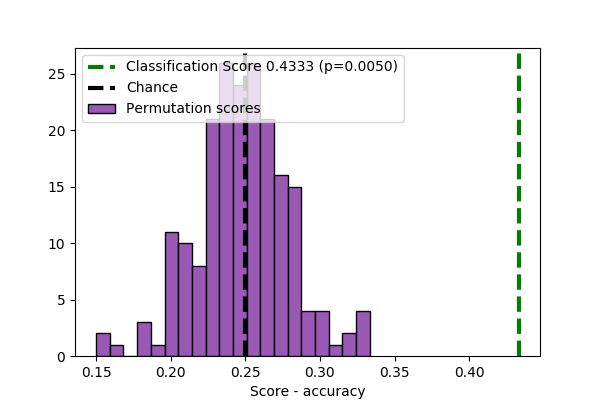

permutation_test_train_size27_37_7_x-14_y_sz.png


In [2971]:
if permutation_test:
    
    # View histogram of permutation scores            
    fig = pl.figure(figsize=(6,4))
    n_classes = np.unique([cy]).size

    pl.hist(permutation_scores, 20, label='Permutation scores', edgecolor='black')
    ylim = pl.ylim()
    pl.plot(2 * [score], ylim, '--g', linewidth=3, label='Classification Score %.4f (p=%.4f)' % (score, pvalue))
    pl.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance')
    pl.ylim(ylim)
    pl.legend()
    pl.xlabel('Score - %s' % scoring)

    figname = 'permutation_test'
    if train_transform_subset:
        figname = '%s_train_%s%s' % (figname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))

    
    if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
        figname = '%s_x%s_y%s_sz%s.png' % (figname, '_'.join([str(int(x)) for x in xpos]), \
                                  '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))
    else:
        figname = '%s.png' % figname

    pl.savefig(os.path.join(output_dir, figname))
    print(figname)

###### Get confusion matrix

Getting cv folds for confusion matrix (labels: [0.0, 90.0, 180.0, 270.0])
Normalized confusion matrix


<IPython.core.display.Javascript object>


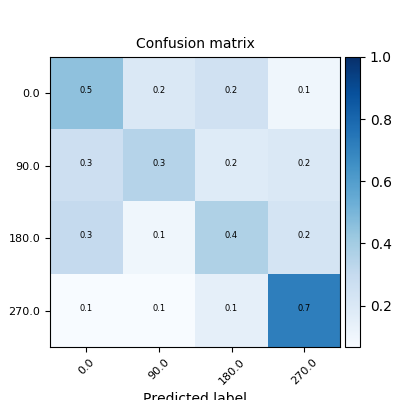

confusion_matrix_train_size27_37_7_x-14_y_sz.png


In [2980]:
print("Getting cv folds for confusion matrix (labels: %s)" % str(train_labels))

loo = cross_validation.StratifiedKFold(xlabels, n_folds=cv_nfolds, shuffle=True)
predicted = []
true = []
cv_train_ixs = [] 
cv_test_ixs = []
for train, test in loo: #, groups=groups):
    #print train, test
    cv_train, cv_test = xdata[train,:], xdata[test,:]
    cv_train_labels, cv_test_labels = xlabels[train], xlabels[test]
    
    y_pred = svc.fit(cv_train, cv_train_labels).predict(cv_test)
    
    predicted.append(y_pred)
    true.append(cv_test_labels)
    cv_train_ixs.append(train)
    cv_test_ixs.append(test)
    

cmatrix = None
if not isinstance(predicted[0], (int, float, str)) and len(predicted[0]) > 1:
    cmatrix = confusion_matrix(true[0], predicted[0], labels=train_labels)
    for iter_idx in range(len(predicted))[1:]:
        #print "adding iter %i" % iter_idx
        cmatrix += confusion_matrix(true[iter_idx], predicted[iter_idx], labels=train_labels)
    conf_mat_str = 'AVG'
    
plot_confusion_matrix(cmatrix, train_labels, normalize=True)
figname = 'confusion_matrix'
if train_transform_subset:
    figname = '%s_train_%s%s' % (figname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))
      
if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
    figname = '%s_x%s_y%s_sz%s.png' % (figname, '_'.join([str(int(x)) for x in xpos]), \
                                  '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))
else:
    figname = '%s.png' % figname

pl.savefig(os.path.join(output_dir, figname))
print(figname)

###### Look at CV accuracy by stimulus condition:

In [2981]:
config_sorter = 'size' #'size' #'xpos' #'morphlevel' #'position'

if config_sorter is not None:
    sort_configs = list(set([d.conditions.loc[cfg][config_sorter] for cfg in trainlabels]))
    print(sort_configs)

print(trainlabels.shape)
print(xdata.shape)

[27.0, 37.0, 7.0]
(240,)
(240, 13)


In [2982]:
results_by_config = {}

# Sort CV results by config_sorter (even if trained class is different):

for fold, (pred,tru,ixs) in enumerate(zip(predicted, true, cv_test_ixs)):
    corresp_configs = trainlabels[ixs] # True config labels of tested samples in current cv fold
    configs_tested = list(set(corresp_configs))
    
    for cfg in configs_tested:
        curr_sort_value = d.conditions.loc[cfg][config_sorter]
        if curr_sort_value not in results_by_config.keys():
            results_by_config[curr_sort_value] = {}
        if fold not in results_by_config[curr_sort_value].keys():
            results_by_config[curr_sort_value][fold] = []

        # Get index in curr fold for current config:
        fold_ixs = [i for i, c in enumerate(corresp_configs) if c==cfg]
        if train_transform_subset is False:
            assert all([t==curr_sort_value for t in tru[fold_ixs]])
        ncorrect = [1 if p==t else 0 for p, t in zip(pred[fold_ixs], tru[fold_ixs])]
        results_by_config[curr_sort_value][fold].extend(ncorrect)
        results_by_config[curr_sort_value][fold].extend(ncorrect)
        

In [2983]:

average_scores_by_config = {}
sem_scores_by_config={}
std_scores_by_config={}

for sort_value in sort_configs:
    average_scores_by_config[sort_value] = np.mean([np.mean(results_by_config[sort_value][k]) for k in range(cv_nfolds)])
    sem_scores_by_config[sort_value] = stats.sem([np.mean(results_by_config[sort_value][k]) for k in range(cv_nfolds)])
    std_scores_by_config[sort_value] = np.std([np.mean(results_by_config[sort_value][k]) for k in range(cv_nfolds)])

average_scores_by_config


{7.0: 0.43302564102564095,
 27.0: 0.46741886596375765,
 37.0: 0.51666666666666672}

<IPython.core.display.Javascript object>


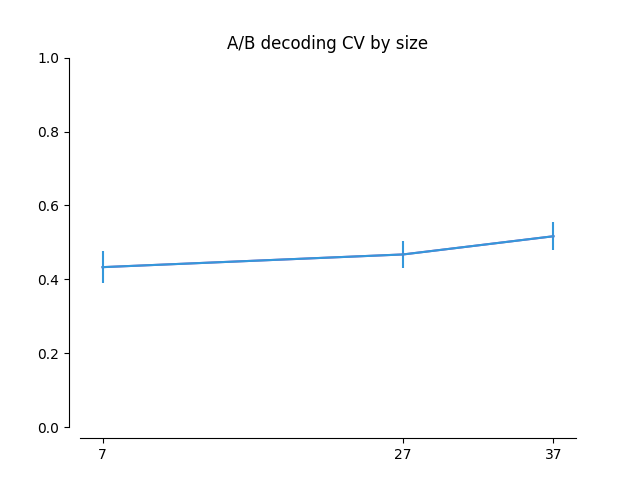

cv_accuracy_by_size_train_size27_37_7_x-14_y_sz


In [2984]:
# Plot CV accuracy by trained transform:

plot_sem = True


fig, ax = pl.subplots() #pl.figure()
x = sorted(average_scores_by_config.keys())
y = [v for k, v in sorted(average_scores_by_config.items(), key=lambda x: x[0])]
if plot_sem:
    yerr = [v for k, v in sorted(sem_scores_by_config.items(), key=lambda x: x[0])]
else:
    yerr = [v for k, v in sorted(std_scores_by_config.items(), key=lambda x: x[0])]


pl.plot(x, y)
pl.errorbar(x=x, y=y, yerr=yerr)

ax.set_xticks([k for k in sorted(average_scores_by_config.keys())])
ax.set_xticklabels([int(k) for k in sorted(average_scores_by_config.keys())])
ax.set_ylim([0, 1])
pl.title("A/B decoding CV by %s" % config_sorter)
sns.despine(offset=8)

figname = 'cv_accuracy_by_%s' % config_sorter
if train_transform_subset:
    figname = '%s_train_%s%s' % (figname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))
if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
    figname = '%s_x%s_y%s_sz%s' % (figname, '_'.join([str(int(x)) for x in xpos]), \
                                  '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))

pl.savefig(os.path.join(output_dir, '%s.png' % figname))
print(figname)

In [1975]:
if config_sorter == 'position' or config_sorter == 'xpos':
    xvals = list(set([float(pos.split('_')[0]) for pos in positions]))
    if config_sorter == 'xpos':
        yvals = ypos
        print(yvals)
    else:
        yvals = list(set([float(pos.split('_')[1]) for pos in positions]))
    print("%i xvals, %i yvals" % (len(xvals), len(yvals)))
    nxpos = len(xvals)
    nypos = len(yvals)
    accuracy_grid = np.empty((nypos, nxpos))

    print(accuracy_grid)
else:
    accuracy_grid = None
    ypos_test = ypos
    xpos_test = xpos

In [2985]:


if config_sorter == 'position' or config_sorter == 'xpos':

    for yi, y in enumerate(sorted(yvals)):
        for xi, x in enumerate(sorted(xvals)):
            if config_sorter == 'position':
                pos_str = '%.1f_%.1f' % (x, y)
            else:
                pos_str = x
            print(pos_str)
            if pos_str not in average_scores_by_config.keys():
                #print pos_str
                score = 0
            else:
                score = average_scores_by_config[pos_str]
            accuracy_grid[yi, xi] = score

    fig, ax = pl.subplots(figsize=(8,4)) #pl.figure()
    sns.heatmap(accuracy_grid, vmin=0, vmax=1, ax=ax, cmap="hot",
                annot=True, xticklabels=sorted(xvals), yticklabels=sorted(yvals))
    # ax.set_xticks(np.arange(nxpos))
    # ax.set_xticklabels([str(i) for i in xpos])

    # ax.set_yticks(np.arange(nypos))
    # ax.set_yticklabels([str(i) for i in ypos])

    # pl.colorbar()
    pl.savefig(os.path.join(output_dir, 'CV_accuracy_decode_%s_by_%s_heatmap.png' % (class_name, config_sorter)))

#### Save CV results:

In [2986]:
results_fname = 'results_%s' % fov_dirname

results_fname = 'results_%s' % fov_dirname
if train_transform_subset:
    results_fname = '%s_train_%s%s' % (results_fname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))

if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
    results_fname = '%s_x%s_y%s_sz%s' % (results_fname, '_'.join([str(int(x)) for x in xpos]), \
                                  '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))


results_outfile = os.path.join(output_dir, '%s.pkl' % results_fname)
print("Saving: %s" % results_outfile)

results = {'average_scores_by_config': average_scores_by_config,
             'sem_scores_by_config': sem_scores_by_config,
             'std_scores_by_config': std_scores_by_config,
             'svc': svc,
             'roi_indices': roi_indices,
             'C': svc.C
          }

if train_transform_subset:
    results.update({'train_transforms': train_transforms,
                  'test_transforms': test_transforms})

with open(results_outfile, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
print(results_outfile)

Saving: /n/coxfs01/2p-data/JC026/LI/20181209_FOV1_traces001/classifiers/decode_ori_train_test_size/results_20181209_FOV1_traces001_train_size27_37_7_x-14_y_sz.pkl
/n/coxfs01/2p-data/JC026/LI/20181209_FOV1_traces001/classifiers/decode_ori_train_test_size/results_20181209_FOV1_traces001_train_size27_37_7_x-14_y_sz.pkl


#### Combine single-transform trained CV results:

In [2480]:
trained_transform = 'size'

V1_results = glob.glob(os.path.join(D.rootdir, 'JC*', 'V1', '*FOV*', 'classifiers', 'decode_ori_train_test_size_single', 'results_*.pkl'))
# for vi, vpath in enumerate(V1_results):
#     print(vi, os.path.split(vpath)[-1])
    
LI_results = glob.glob(os.path.join(D.rootdir, 'JC*', 'LI', '*FOV*', 'classifiers', 'decode_ori_train_test_size_single', 'results_*.pkl'))
# for vi, vpath in enumerate(LI_results):
#     print(vi, os.path.split(vpath)[-1])
    
V1_values = [int(os.path.splitext(vpath)[0].split('_sz')[-1]) for vpath in V1_results]
V1_values

LI_values = [int(os.path.splitext(vpath)[0].split('_sz')[-1]) for vpath in LI_results]
LI_values

V1 = {}
LI = {}
for vi, (val1, val2) in enumerate(zip(sorted(V1_values), sorted(LI_values))):
    fpath = [f for f in V1_results if 'sz%i' % val1 in f][0]
    with open(fpath, 'rb') as f: 
        res = pkl.load(f)
    V1[vi] = res
    
    fpath = [f for f in LI_results if 'sz%i' % val2 in f][0]
    with open(fpath, 'rb') as f: 
        res = pkl.load(f)
    LI[vi] = res
    

In [2240]:
CV = {'V1': {}, 'LI': {}}

for vi, val in enumerate(sorted(V1_values)):
    CV['V1'][val] = np.mean([av_score for classlabel, av_score in V1[vi]['average_scores_by_config'].items()])
for vi, val in enumerate(sorted(LI_values)):
    CV['LI'][val] = np.mean([av_score for classlabel, av_score in LI[vi]['average_scores_by_config'].items()])

In [2241]:
CV

{'LI': {10: 0.34999999999999998,
  16: 0.52499999999999991,
  22: 0.51249999999999996,
  28: 0.52499999999999991,
  34: 0.66249999999999998},
 'V1': {10: 0.36249999999999999,
  15: 0.28749999999999998,
  20: 0.40000000000000002,
  25: 0.38749999999999996,
  30: 0.26250000000000001}}

In [2242]:
# trained_transform = 'size'
# all_cfg_values = list(set(d.conditions['%s' % trained_transform]))
# print("%s:" % config_sorter, all_cfg_values)

# cv_results = [glob.glob(os.path.join(output_dir, 'results*_sz%i.pkl' % int(sz)))[0] for sz in all_cfg_values]

# cv_scores = {}
# for cval in all_cfg_values:
#     cv_result = glob.glob(os.path.join(output_dir, 'results*_sz%i.pkl' % int(cval)))[0]
#     with open(cv_result, 'rb') as f:
#         cvr = pkl.load(f)
#     cv_scores[cval] = cvr


In [2243]:
output_dir

'/n/coxfs01/2p-data/JC013/LI/20180907_FOV2_traces001/classifiers/decode_ori_train_test_size_single'

<IPython.core.display.Javascript object>


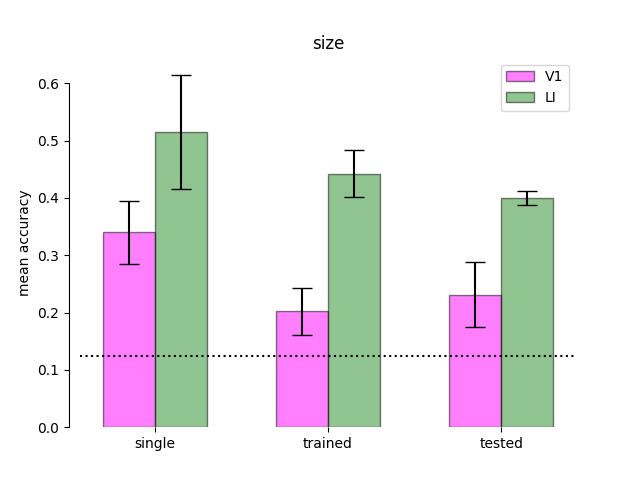

average_CV_by_size_singletrain2


In [2244]:
# width of the bars
barw = 0.3
 
# Choose the height of the blue bars
bars1 = [np.mean(CV['V1'].values()), trained_scores['V1'], tested_scores['V1']]
 
# Choose the height of the cyan bars
bars2 = [np.mean(CV['LI'].values()), trained_scores['LI'], tested_scores['LI']]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(CV['V1'].values()), trained_std['V1'], tested_std['V1']]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(CV['LI'].values()), trained_std['LI'], tested_std['LI']]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barw for x in r1]
 
pl.figure()
# Create blue bars
pl.bar(r1, bars1, width = barw, color = 'magenta', yerr=yer1, label='V1',
      capsize=7, alpha=0.5, edgecolor='None')
 
# Create cyan bars
pl.bar(r2, bars2, width = barw, color='forestgreen', yerr=yer2, label='LI',
      capsize=7, alpha=0.5, edgecolor='None') 
 
# general layout
pl.xticks([r + barw*0.5 for r in range(len(bars1))], ['single', 'trained', 'tested'])
pl.ylabel('mean accuracy')
pl.legend()

pl.title('size')

pl.axhline(y=chance_level, color='k', linestyle=':')
# Show graphic
# pl.show()
sns.despine(trim=True, offset=8, bottom=True)


figname = 'average_CV_by_%s_singletrain2' % (trained_transform) #config_sorter
# if train_transform_subset:
#     figname = '%s_train_%s%s' % (figname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))
# if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
#     figname = '%s_x%s_y%s_sz%s' % (figname, '_'.join([str(int(x)) for x in xpos]), \
#                                   '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))

pl.savefig(os.path.join(output_dir, '%s.png' % figname))
print(figname)

# Train classifier

In [2987]:
C = bestC # bestC
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=C) #, C=self.clfparams['C_val'])
svc.fit(xdata, xlabels)


LinearSVC(C=0.0022229964825261957, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0)

In [2988]:
# Test samples:

predictions = svc.predict(xdata_test)


In [2989]:
print(xlabels_test)

[  90.  270.  180.    0.  180.   90.    0.  270.  180.   90.  270.    0.
   90.    0.  270.  180.  180.   90.    0.  270.    0.  270.  180.   90.
    0.  270.  180.   90.  270.  180.   90.    0.   90.  180.    0.  270.
    0.  270.   90.  180.    0.  270.  180.   90.  270.    0.   90.  180.
  180.   90.    0.  270.  270.  180.   90.    0.  180.   90.  270.    0.
  180.  270.    0.   90.  270.  180.    0.   90.  180.  270.   90.    0.
  180.   90.    0.  270.  180.  270.    0.   90.]


In [2990]:
correct_choices = [1 if p==t else 0 for p, t in zip(predictions, xlabels_test)]
print(np.mean(correct_choices))

0.4


In [2991]:
test_scores_by_config = {}
for cfg in list(set(testlabels)):
    curr_value = d.conditions.loc[cfg][config_sorter]
    
    curr_indices = np.where(testlabels==cfg) # index into predictions and "class labeled" test_labels
    correct = [1 if p==t else 0 for p, t in zip(predictions[curr_indices], xlabels_test[curr_indices])]
    if curr_value not in test_scores_by_config.keys():
        test_scores_by_config[curr_value] = []
        
    test_scores_by_config[curr_value].extend(correct)

In [2992]:
print(test_scores_by_config.keys())


[17.0]


In [2993]:
print("Train transform values:", average_scores_by_config.keys())
print("Test transform values:", test_scores_by_config.keys())
print(test_scores_by_config)

Train transform values: [27.0, 37.0, 7.0]
Test transform values: [17.0]
{17.0: [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]}


In [2994]:
test_scores = {}
for tlabel in test_scores_by_config.keys():
    test_scores[tlabel] = np.mean(test_scores_by_config[tlabel])

print(test_scores)

{17.0: 0.40000000000000002}


In [2995]:
from matplotlib.patches import Rectangle

if config_sorter == 'position' or config_sorter=='xpos':
    for yi, y in enumerate(sorted(yvals)):
        for xi, x in enumerate(sorted(xvals)):
            if config_sorter == 'position':
                pos_str = '%.1f_%.1f' % (x, y)
            else:
                pos_str = x
            if pos_str not in average_scores_by_config.keys():
                #print pos_str
                score = test_scores[pos_str]
            else:
                score = average_scores_by_config[pos_str]
            accuracy_grid[yi, xi] = score

    fig, ax = pl.subplots(figsize=(8,4)) #pl.figure()
    sns.heatmap(accuracy_grid, vmin=0, vmax=1, ax=ax, cmap="hot",
                annot=True, xticklabels=sorted(xvals), yticklabels=sorted(yvals))
    if config_sorter == 'position':
        ypos_test = list(set([float(pos.split('_')[1]) for pos in test_scores.keys()]))
        xpos_test = list(set([float(pos.split('_')[0]) for pos in test_scores.keys()]))

    test_box_x = [sorted(xvals).index(tx) for tx in xpos_test][0]
    test_box_y = [sorted(yvals).index(ty) for ty in ypos_test][0]
    ax.add_patch(Rectangle((test_box_x, test_box_y), len(xpos_test), len(ypos_test), fill=False, 
                           edgecolor='cornflowerblue', lw=3))
    pl.savefig(os.path.join(output_dir, 'decode_%s_by_%s_heatmap.png' % (class_name, config_sorter)))

In [2996]:
chance_level = 1./len(train_labels)
print("chance:", chance_level)

chance: 0.25


In [2997]:
results_fname = 'results_%s' % fov_dirname

results_fname = 'results_%s' % fov_dirname
if train_transform_subset:
    results_fname = '%s_train_%s%s' % (results_fname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))

if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
    results_fname = '%s_x%s_y%s_sz%s' % (results_fname, '_'.join([str(int(x)) for x in xpos]), \
                                  '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))


results_outfile = os.path.join(output_dir, '%s.pkl' % results_fname)
print("Saving: %s" % results_outfile)


results = {'average_scores_by_config': average_scores_by_config,
             'sem_scores_by_config': sem_scores_by_config,
             'std_scores_by_config': std_scores_by_config,
             'svc': svc,
             'roi_indices': roi_indices,
             'C': svc.C
          }

if train_transform_subset:
    results.update({'train_transforms': train_transforms,
                  'test_transforms': test_transforms})
    
results.update({
 'test_scores_by_config': test_scores_by_config,
 'accuracy_grid' : accuracy_grid,
 'ypos_test': ypos_test,
 'xpos_test' : xpos_test
})
    

with open(results_outfile, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
print(results_outfile)

Saving: /n/coxfs01/2p-data/JC026/LI/20181209_FOV1_traces001/classifiers/decode_ori_train_test_size/results_20181209_FOV1_traces001_train_size27_37_7_x-14_y_sz.pkl
/n/coxfs01/2p-data/JC026/LI/20181209_FOV1_traces001/classifiers/decode_ori_train_test_size/results_20181209_FOV1_traces001_train_size27_37_7_x-14_y_sz.pkl


#### PLOT

<IPython.core.display.Javascript object>


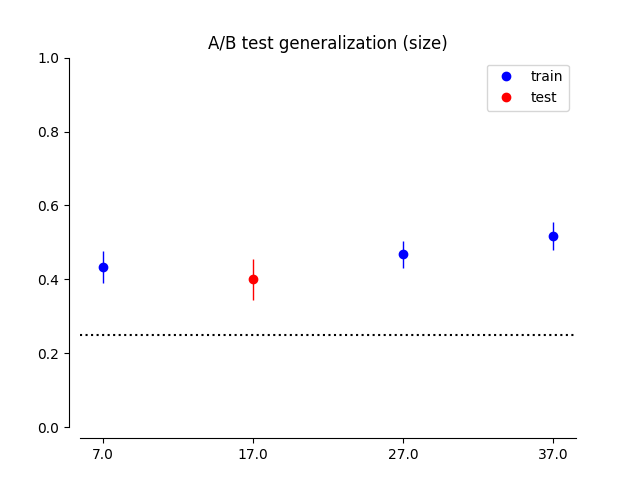

decode_ori_by_size_linear_train_size27_37_7_sem_x-14_y.png


In [2998]:
plot_sem = True

fig, ax = pl.subplots() #pl.figure()
x = sorted(average_scores_by_config.keys())
y = [v for k, v in sorted(average_scores_by_config.items(), key=lambda x: x[0])]

if plot_sem:
    yerr = [v for k, v in sorted(sem_scores_by_config.items(), key=lambda x: x[0])]
else:
    yerr = [v for k, v in sorted(std_scores_by_config.items(), key=lambda x: x[0])]

ax.plot(x, y, marker='o', markerfacecolor='b', markeredgecolor='b', linestyle='None', label='train')
ax.errorbar(x=x, y=y, yerr=yerr, ecolor='b', elinewidth=1, linestyle='None')


test_x = sorted(test_scores_by_config.keys())
test_y = [np.mean(vals) for k, vals in sorted(test_scores_by_config.items(), key=lambda x:x[0])]
if plot_sem:
    test_yerr = [stats.sem(vals) for k, vals in sorted(test_scores_by_config.items(), key=lambda x:x[0])]
else:
    test_yerr = [np.std(vals) for k, vals in sorted(test_scores_by_config.items(), key=lambda x:x[0])]

ax.plot(test_x, test_y, marker='o', markerfacecolor='r', markeredgecolor='r', linestyle='None', label='test')
ax.errorbar(x=test_x, y=test_y, yerr=test_yerr, ecolor='r', elinewidth=1, linestyle='None')

pl.ylim([0, 1])
xlabels = copy.copy(x)
xlabels.extend(test_x)
ax.set_xticks(sorted(xlabels))
ax.set_xticklabels(sorted(xlabels))

pl.title("A/B test generalization (%s)" % config_sorter)
sns.despine(offset=8)
pl.legend()

chance_level = 1./len(train_labels)
ax.axhline(y=chance_level, color='k', linestyle=':')


figname = 'decode_%s_by_%s_linear' % (class_name, config_sorter)
if train_transform_subset:
    figname = '%s_train_%s%s' % (figname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))

if plot_sem:
    figname = '%s_sem' % figname
    
if len(xpos) > 0 or len(ypos) > 0:
    figname = '%s_x%s_y%s.png' % (figname, '_'.join([str(int(x)) for x in xpos]), '_'.join([str(int(y)) for y in ypos]))
else:
    figname = '%s.png' % figname
    
    
pl.savefig(os.path.join(output_dir, figname))
print(figname)

In [3007]:
results_V1 = glob.glob(os.path.join(D.rootdir, 'JC*', 'V1', '*FOV*', 'classifiers',\
                                    'decode_ori_train_test_size', 'results*.pkl'))
#print(results_V1)

results_LI = glob.glob(os.path.join(D.rootdir, 'JC*', 'LI*', '*FOV*', 'classifiers',\
                                    'decode_ori_train_test_size', 'results*.pkl'))
results_LI_tmp = [f for f in results_LI if 'JC026' not in f]

#add_jc026 = [f for f in results_LI if 'JC026' in f and '_x-14' in f][0]

results_LI = copy.copy(results_LI_tmp)
#results_LI.append(add_jc026)


#print(results_LI)

V1 = {'train_scores': [], 'test_scores': []}
LI = {'train_scores': [], 'test_scores': []}
for fpath in results_V1:
    with open(fpath, 'rb') as f:
        tmpV1 = pkl.load(f)
    V1['train_scores'].append(np.mean([v for k, v in tmpV1['average_scores_by_config'].items()]))
    V1['test_scores'].append(np.mean([v for k, v in tmpV1['test_scores_by_config'].items()]))
    V1['nvalues'] = len(tmpV1['average_scores_by_config'].keys())
    
for fpath in results_LI:
    with open(fpath, 'rb') as f:
        tmpLI = pkl.load(f)
    if 'test_scores_by_config' not in tmpLI.keys():
        print(fpath)
        continue
    LI['train_scores'].append(np.mean([v for k, v in tmpLI['average_scores_by_config'].items()]))
    LI['test_scores'].append(np.mean([v for k, v in tmpLI['test_scores_by_config'].items()]))
    LI['nvalues'] = len(tmpLI['average_scores_by_config'].keys())

    
# trained_scores = {'V1': np.mean([v for k, v in V1['average_scores_by_config'].items()]),
#                   'LI': np.mean([v for k, v in LI['average_scores_by_config'].items()])}
# trained_std = {'V1': np.std([v for k, v in V1['average_scores_by_config'].items()]),
#                'LI': np.std([v for k, v in LI['average_scores_by_config'].items()])}


# tested_scores = {'V1': np.mean([np.mean(v) for k, v in V1['test_scores_by_config'].items()]),
#                   'LI': np.mean([np.mean(v) for k, v in LI['test_scores_by_config'].items()])}
# tested_std = {'V1': np.std([np.mean(v) for k, v in V1['test_scores_by_config'].items()]),
#               'LI': np.std([np.mean(v) for k, v in LI['test_scores_by_config'].items()])}


In [3010]:
chance_level = 1/8.

<IPython.core.display.Javascript object>


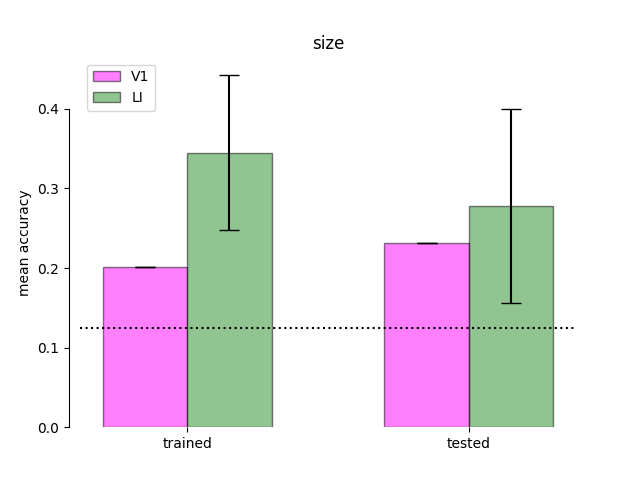

In [3011]:
# width of the bars
barw = 0.3
 
# Choose the height of the blue bars
bars1 = [np.mean(V1['train_scores']), np.mean(V1['test_scores'])]
 
# Choose the height of the cyan bars
bars2 = [np.mean(LI['train_scores']), np.mean(LI['test_scores'])]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(V1['train_scores']), np.std(V1['test_scores'])]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(LI['train_scores']), np.std(LI['test_scores'])]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barw for x in r1]
 
pl.figure()
# Create blue bars
pl.bar(r1, bars1, width = barw, color = 'magenta', yerr=yer1, label='V1',
      capsize=7, alpha=0.5, edgecolor='None')
 
# Create cyan bars
pl.bar(r2, bars2, width = barw, color='forestgreen', yerr=yer2, label='LI',
      capsize=7, alpha=0.5, edgecolor='None') 
 
# general layout
pl.xticks([r + barw*0.5 for r in range(len(bars1))], ['trained', 'tested'])
pl.ylabel('mean accuracy')
pl.legend()

pl.title('size')

pl.axhline(y=chance_level, color='k', linestyle=':')
# Show graphic
# pl.show()
sns.despine(trim=True, offset=8, bottom=True)

<IPython.core.display.Javascript object>


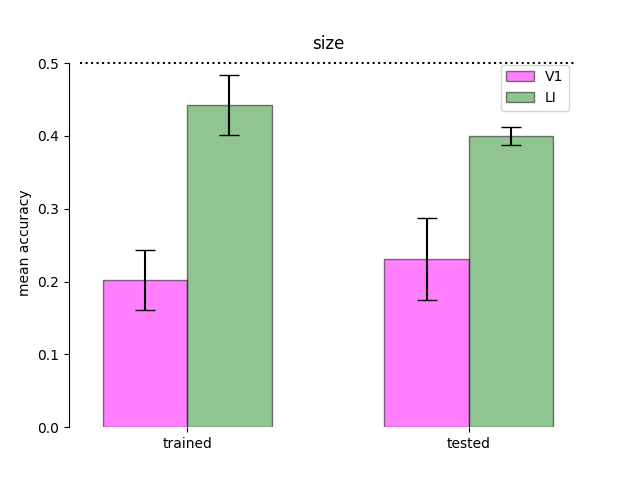

In [2775]:
# width of the bars
barw = 0.3
 
# Choose the height of the blue bars
bars1 = [trained_scores['V1'], tested_scores['V1']]
 
# Choose the height of the cyan bars
bars2 = [trained_scores['LI'], tested_scores['LI']]
 
# Choose the height of the error bars (bars1)
yer1 = [trained_std['V1'], tested_std['V1']]
 
# Choose the height of the error bars (bars2)
yer2 = [trained_std['LI'], tested_std['LI']]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barw for x in r1]
 
pl.figure()
# Create blue bars
pl.bar(r1, bars1, width = barw, color = 'magenta', yerr=yer1, label='V1',
      capsize=7, alpha=0.5, edgecolor='None')
 
# Create cyan bars
pl.bar(r2, bars2, width = barw, color='forestgreen', yerr=yer2, label='LI',
      capsize=7, alpha=0.5, edgecolor='None') 
 
# general layout
pl.xticks([r + barw*0.5 for r in range(len(bars1))], ['trained', 'tested'])
pl.ylabel('mean accuracy')
pl.legend()

pl.title('size')

pl.axhline(y=chance_level, color='k', linestyle=':')
# Show graphic
# pl.show()
sns.despine(trim=True, offset=8, bottom=True)

In [2917]:
LI

{'C': 0.00013257113655901109,
 'average_scores_by_config': {15.0: 0.26617647058823535,
  25.0: 0.24663484692122464,
  35.0: 0.22907647907647907},
 'roi_indices': array([ 1,  4,  5, 16, 28, 31, 36, 38, 39, 42, 44, 46, 51]),
 'sem_scores_by_config': {15.0: 0.070003707267128845,
  25.0: 0.01937863105554416,
  35.0: 0.057700330322896835},
 'std_scores_by_config': {15.0: 0.14000741453425772,
  25.0: 0.03875726211108832,
  35.0: 0.11540066064579368},
 'svc': LinearSVC(C=0.00013257113655901109, class_weight=None, dual=True,
      fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
      max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
      tol=0.0001, verbose=0),
 'test_transforms': [20, 30],
 'train_transforms': [25.0, 35.0, 15.0]}

<IPython.core.display.Javascript object>


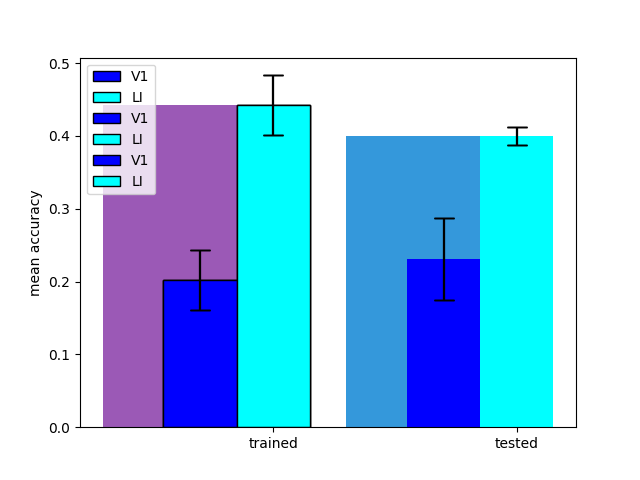

<Container object of 1 artists>

In [1153]:

trained_avg_score = np.mean([v for k, v in average_scores_by_config.items()])
trained_avg_score_std = np.std([v for k, v in average_scores_by_config.items()])

tested_avg_score = np.mean([np.mean(v) for k, v in test_scores_by_config.items()])
testd_avg_score_std = np.std([np.mean(v) for k, v in test_scores_by_config.items()])

fig, ax = pl.subplots()
pl.bar(0, trained_avg_score)
pl.bar(1, tested_avg_score)

# Plot morph decoding 

In [2776]:
choices = {}
for test_value in test_scores_by_config.keys():
    print(test_value)
    curr_indices = np.where(xlabels_test==test_value)[0]
    choices[test_value] = predictions[curr_indices]
choices

66.0
40.0
14.0
79.0
53.0
27.0
92.0


{14.0: array([   0.,  106.,    0.,  106.,  106.,  106.,    0.,    0.,    0.,
         106.,    0.,    0.,  106.,    0.,  106.,  106.,    0.,  106.,
           0.,    0.]),
 27.0: array([   0.,    0.,    0.,    0.,    0.,  106.,  106.,  106.,    0.,
         106.,    0.,  106.,  106.,  106.,  106.,  106.,  106.,    0.,
         106.,  106.]),
 40.0: array([   0.,  106.,  106.,    0.,    0.,    0.,  106.,    0.,    0.,
           0.,  106.,  106.,    0.,  106.,  106.,  106.,  106.,  106.,
           0.,    0.]),
 53.0: array([   0.,    0.,  106.,  106.,    0.,    0.,  106.,  106.,    0.,
           0.,  106.,    0.,  106.,    0.,    0.,  106.,  106.,    0.,
           0.,  106.]),
 66.0: array([   0.,    0.,  106.,    0.,    0.,    0.,    0.,  106.,    0.,
           0.,  106.,  106.,    0.,  106.,  106.,  106.,    0.,    0.,
         106.,  106.]),
 79.0: array([   0.,    0.,  106.,  106.,    0.,  106.,  106.,    0.,    0.,
         106.,  106.,  106.,    0.,    0.,  106.,  106.,  106.,

In [2777]:
test_scores_by_config.keys()

[66.0, 40.0, 14.0, 79.0, 53.0, 27.0, 92.0]

In [2778]:
train_labels

[0.0, 106.0]

In [2779]:
all_morph_levels = sorted(list(set(d.conditions['morphlevel'])))
print(all_morph_levels)
#all_morph_levels = [0, 27, 53, 79, 106]
pchoose100 = {}; pchoose100_sem = {};

for morph in all_morph_levels:
    if morph in train_labels:
        mean_cv = []
        for pred, tru in zip(predicted, true):
            curr_trials = np.where(tru==morph)[0]
            mean_cv.append(np.mean([1 if p==106 else 0 for p in pred[curr_trials]]))
        pchoose100[morph] = np.mean(mean_cv)
        pchoose100_sem[morph] = stats.sem(mean_cv)
    else:
        pchoose100[morph] = np.mean([1 if p==106 else 0 for p in choices[morph]])
        pchoose100_sem[morph] = stats.sem([1 if p==106 else 0 for p in choices[morph]])

pchoose100

[0.0, 14.0, 27.0, 40.0, 53.0, 66.0, 79.0, 92.0, 106.0]


{0.0: 0.29999999999999999,
 14.0: 0.45000000000000001,
 27.0: 0.59999999999999998,
 40.0: 0.5,
 53.0: 0.45000000000000001,
 66.0: 0.45000000000000001,
 79.0: 0.55000000000000004,
 92.0: 0.5,
 106.0: 0.65000000000000002}

In [2780]:

results.update({'pchoose100': pchoose100,
                'pchoose100_sem': pchoose100_sem,
                'all_morph_levels': all_morph_levels})


with open(results_outfile, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
print(results_outfile)

/n/coxfs01/2p-data/JC026/LI/20181209_FOV1_traces001/classifiers/decode_AB_train_anchors_test_morphs/results_20181209_FOV1_traces001_x-14_y5_sz


In [2781]:
mean_cv

[1.0, 1.0, 0.0, 0.75, 0.5]

<IPython.core.display.Javascript object>


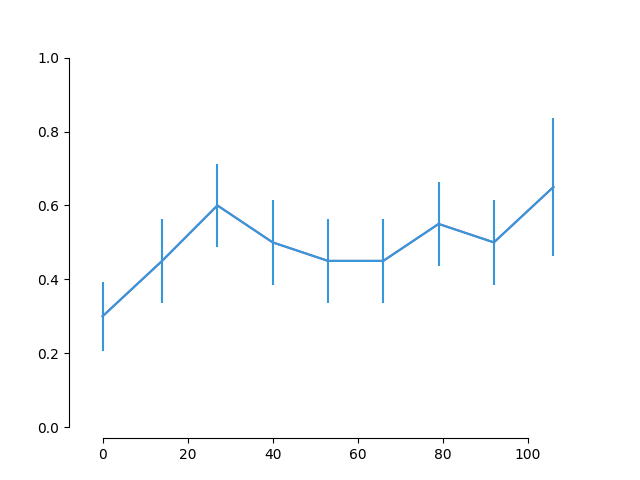

[0.093541434669348528, 0.11413288653790232, 0.11239029738980327, 0.11470786693528086, 0.11413288653790232, 0.11413288653790232, 0.11413288653790232, 0.11470786693528086, 0.18708286933869706]
train_anchors_test_morphs_psychometric_9morphs2_x-14_y5.png
/n/coxfs01/2p-data/JC026/LI/20181209_FOV1_traces001/classifiers/decode_AB_train_anchors_test_morphs


In [2782]:
pl.figure()
x = sorted(all_morph_levels)
y = [v for k, v in sorted(pchoose100.items(), key=lambda x: x[0])]
yerr = [v for k, v in sorted(pchoose100_sem.items(), key=lambda x: x[0])]
print(yerr)
pl.plot(x, y)
pl.errorbar(x=x, y=y, yerr=yerr)
pl.ylim([0, 1])
sns.despine(offset=8, trim=True)

figname = 'train_anchors_test_morphs_psychometric_%imorphs2' % len(all_morph_levels)
if len(xpos) > 0 or len(ypos) > 0:
    figname = '%s_x%s_y%s.png' % (figname, '_'.join([str(int(x)) for x in xpos]), '_'.join([str(int(y)) for y in ypos]))
else:
    figname = '%s.png' % figname
print(figname)
    
pl.savefig(os.path.join(output_dir, figname))

print(output_dir)

In [585]:
print(output_dir)

/n/coxfs01/2p-data/JC022/LI_LL/20181016_FOV2_traces001/classifiers/decode_AB_train_anchors_test_morphs


In [845]:
results_files = glob.glob(os.path.join(D.rootdir, D.animalid, visual_area, '*FOV*', 'classifiers', '*train*_*morphs*', 'results_*.pkl'))
print(results_files)
visual_area_dir = os.path.join(D.rootdir, D.animalid, visual_area)
print(visual_area_dir)

['/n/coxfs01/2p-data/JC022/LI_LL/20181018_FOV2_traces001/classifiers/decode_AB_train_anchors_test_morphs2/results_20181018_FOV2_traces001.pkl', '/n/coxfs01/2p-data/JC022/LI_LL/20181016_FOV2_traces001/classifiers/decode_AB_train_anchors_test_morphs/results_20181016_FOV2_traces001.pkl']
/n/coxfs01/2p-data/JC022/LI_LL


In [846]:
p100 = dict()
p100_sem = dict()
session_list = []
for f in results_files:
    curr_session = f.split('%s/' % visual_area)[1].split('_FOV')[0]
    session_list.append(curr_session)
    with open(f, 'rb') as f: 
        res = pkl.load(f)
        if curr_session == '20181018':
            print(res.keys())
        for mkey, prob in res['pchoose100'].items():
            if mkey not in p100.keys():
                p100[mkey] = []
            p100[mkey].append(prob)
session_list = sorted(session_list, key=natural_keys)
session_list

['ypos_test', 'C', 'sem_scores_by_config', 'xpos_test', 'svc', 'pchoose100', 'roi_indices', 'all_morph_levels', 'pchoose100_sem', 'average_scores_by_config', 'test_scores_by_config', 'accuracy_grid']


['20181016', '20181018']

In [847]:
[str(p) for p in np.arange(0, 125, 25)]
sorted([int(mkey) for mkey in p100.keys()])

[0, 9, 18, 27, 36, 45, 53, 61, 70, 79, 88, 97, 106]

In [851]:
np.arange(0, 100, len(p100.keys()))

array([  0,  13,  26,  39,  52,  65,  78,  91, 104, 117])

<IPython.core.display.Javascript object>


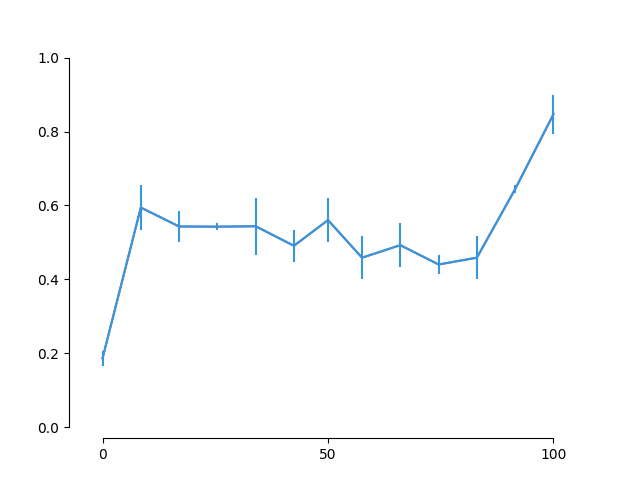

In [853]:
mean_p100 = [(mkey, np.mean(vals)) for mkey, vals in p100.items()]
sem_p100 = [(mkey, stats.sem(vals)) for mkey, vals in p100.items()]

x = [v[0] for v in sorted(mean_p100, key=lambda x: x[0])]
y = [v[1] for v in sorted(mean_p100, key=lambda x: x[0])]
yerr = [v[1] for v in sorted(sem_p100, key=lambda x: x[0])]

fig, ax = pl.subplots()

ax.plot(x, y)
ax.errorbar(x=x, y=y, yerr=yerr)
ax.set_ylim([0, 1])
#ax.set_xticks(sorted([int(mkey) for mkey in p100.keys()]))
ax.set_xticks([0, 53, 106])

ax.set_xticklabels(['0', '50', '100'])
sns.despine(offset=8, trim=True)

figname = 'morphcurve_%s.png' % '_'.join(session_list)
pl.savefig(os.path.join(visual_area_dir, figname))

In [ ]:
pl.figure()
x = sorted(all_morph_levels)
y = [v for k, v in sorted(pchoose100.items(), key=lambda x: x[0])]
yerr = [v for k, v in sorted(pchoose100_sem.items(), key=lambda x: x[0])]
print(yerr)
pl.plot(x, y)
pl.errorbar(x=x, y=y, yerr=yerr)
pl.ylim([0, 1])
sns.despine(offset=8, trim=True)

figname = 'train_anchors_test_morphs_psychometric_%imorphs2' % len(all_morph_levels)
if len(xpos) > 0 or len(ypos) > 0:
    figname = '%s_x%s_y%s.png' % (figname, '_'.join([str(int(x)) for x in xpos]), '_'.join([str(int(y)) for y in ypos]))
else:
    figname = '%s.png' % figname
print(figname)
    
pl.savefig(os.path.join(output_dir, figname))

print(output_dir)

In [35]:
test_data = clf.train_results['test_data']
test_labels = clf.train_results['test_labels']
test_labels_config_names = clf.cy_labels[np.array(clf.train_results['test_labels'].index.tolist())]

In [37]:
test_results = clf.test_classifier(test_data=test_data, 
                                test_labels=test_labels, 
                                config_labels=test_labels_config_names, 
                                include_cv=False)
                
curr_output_dir = clf.classifier_dir

In [43]:
test_results.keys()

['test_labels',
 'results_by_class',
 'predicted_classes',
 'results_by_config',
 'test_data',
 'config_labels']

In [44]:
test_results['results_by_config']

{'config001': {'indices': array([  7,  47,  48,  78,  86, 119, 130]),
  'predicted': array([ 55.,  55.,  45.,  15.,  35.,  15.,  55.]),
  'true': 7       NaN
  47      NaN
  48     25.0
  78      NaN
  86      NaN
  119     NaN
  130     NaN
  dtype: float64},
 'config002': {'indices': array([ 72, 100, 142, 151]),
  'predicted': array([ 45.,  35.,  45.,  45.]),
  'true': 72      NaN
  100     NaN
  142    25.0
  151     NaN
  dtype: float64},
 'config003': {'indices': array([ 36, 122]),
  'predicted': array([ 15.,  15.]),
  'true': 36      NaN
  122    15.0
  dtype: float64},
 'config004': {'indices': array([ 16,  31, 103, 112]),
  'predicted': array([ 55.,  55.,  45.,  35.]),
  'true': 16      NaN
  31     35.0
  103    15.0
  112     NaN
  dtype: float64},
 'config005': {'indices': array([  4,  43,  45,  70, 152, 155]),
  'predicted': array([ 15.,  55.,  35.,  45.,  35.,  55.]),
  'true': 4     NaN
  43    NaN
  45    NaN
  70    NaN
  152   NaN
  155   NaN
  dtype: float64},
 'confi